## ニューラルネットワーク  
隠れ層のレイヤーを2個増やしてみた

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import multivariate_normal, permutation
import pandas as pd
from pandas import DataFrame, Series
from sklearn.model_selection import train_test_split

np.random.seed(20160614)
tf.set_random_seed(20160614)

In [42]:
#snssns..set_styleset_sty ('whitegrid')
%matplotlib inline

pd.set_option("display.max_columns", 200) # 表示カラムの最大値
pd.set_option('display.max_rows', 200) # 表示行数の最大値
pd.set_option('display.max_colwidth', 30)
pd.set_option("display.float_format", '{:.3f}'.format) # 小数点以下の有効数字

# jupyterの幅を自動調整
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### データ読み込み

In [3]:
df = pd.read_csv('../01.data/02.train/data_2013_2017.csv', index_col=0)

In [4]:
# 学習データと検証データに分割
X_train, X_valid, y_train, y_valid = train_test_split(df.iloc[:, 1:df.shape[1]], 
                                                    df['target'], 
                                                    test_size=0.3, 
                                                    random_state=100)
# TensorFlow用に変換
X_train = X_train.as_matrix()
y_train = y_train.as_matrix().reshape([len(y_train), 1])
X_valid = X_valid.as_matrix()
y_valid = y_valid.as_matrix().reshape([len(y_valid), 1])

In [5]:
# 学習データと検証データの正解含有率とレコード件数
print ('train data || Correct Data Rate : %f, Length of data: %i' % (y_train.sum()/len(y_train), len(y_train)))
print ('valid data || Correct Data Rate : %f, Length of data: %i' % (y_valid.sum()/len(y_valid), len(y_valid)))

train data || Correct Data Rate : 0.175234, Length of data: 856
valid data || Correct Data Rate : 0.185286, Length of data: 367


### パラメータ

In [21]:
# make results reproducible
seed = 3
np.random.seed(seed)
tf.set_random_seed(seed)

#  説明変数の数
NUM_VARS = X_train.shape[1]

# 学習率
LEARNING_RATE = 0.0001

# 投資判断しきい値（accuracyの算出で利用）
INVEST_THRESHOLD = 0.5

# バッチサイズ
batch_size = 100

In [22]:
# 説明変数
x = tf.placeholder(shape=[None, NUM_VARS], dtype=tf.float32)
#目的変数
y = tf.placeholder(shape=[None,1], dtype=tf.float32)

In [38]:
 # 隠れ層１のユニット数
NUM_UNITS_1 = 10
# 隠れ層２のユニット数
NUM_UNITS_2 = 5
# 隠れ層3のユニット数
NUM_UNITS_3 = 2

# バイアスの初期値に利用する
mult = X_train.flatten().mean() 

# 隠れ層１を定義
w1 = tf.Variable(tf.truncated_normal([NUM_VARS, NUM_UNITS_1]))
b1 = tf.Variable(tf.zeros([NUM_UNITS_1]))
hidden1 = tf.nn.relu(tf.matmul(x, w1) + b1*mult)

# 隠れ層2を定義
w2 = tf.Variable(tf.truncated_normal([NUM_UNITS_1, NUM_UNITS_2]))
b2 = tf.Variable(tf.zeros([NUM_UNITS_2]))
hidden2 = tf.nn.relu(tf.matmul(hidden1, w2) + b2*mult)

# 隠れ層3を定義
w3 = tf.Variable(tf.truncated_normal([NUM_UNITS_2, NUM_UNITS_3]))
b3 = tf.Variable(tf.zeros([NUM_UNITS_3]))
hidden3 = tf.nn.relu(tf.matmul(hidden2, w3) + b3*mult)

# 出力層を定義
w0 = tf.Variable(tf.zeros([NUM_UNITS_3, 1]))
b0 = tf.Variable(tf.zeros([1]))
p = tf.nn.sigmoid(tf.matmul(hidden3, w0) + b0*mult)

**[SNE-05]** 誤差関数 loss、トレーニングアルゴリズム train_step、正解率 accuracy を定義します。

In [39]:
# 誤差関数  クロスエントロピー
loss = -tf.reduce_sum(y*tf.log(p) + (1-y)*tf.log(1-p))
# トレーニングアルゴリズム
train_step = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(loss)
# 正解率
correct_prediction = tf.equal(tf.sign(p-INVEST_THRESHOLD), tf.sign(y-INVEST_THRESHOLD))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### 学習

In [40]:
sess = tf.Session()

In [41]:
# 変数の初期化
init = tf.global_variables_initializer()
sess.run(init)

saver = tf.train.Saver()
#cwd = os.getcwd() # Windowsのときに必要

i = 0
loss_vec_train = []
loss_vec_valid = []
acc_vec_train = []
acc_vec_valid = []

for _ in range(20000):
    i += 1
    
    batch_index = np.random.choice(len(X_train),  size=batch_size)
    random_X_train = X_train[batch_index]
    random_y_train = y_train[batch_index]
    
    sess.run(train_step, feed_dict={x: random_X_train, y: random_y_train})

    if i % 10 == 0:
        #　トレーニングセットの損失値を保存
        loss_val, acc_val  = sess.run( [loss, accuracy], feed_dict={x: random_X_train, y: random_y_train})
        
        loss_vec_train.append(loss_val / len(random_y_train))   
        acc_vec_train.append(acc_val)
        
        # テストセットの損失値を保存
        loss_val, acc_val = sess.run( [loss, accuracy],  feed_dict={x: X_valid, y: y_valid})
        
        loss_vec_valid.append(loss_val / len(y_valid))
        acc_vec_valid.append(acc_val)

    if i % 100 == 0:
        loss_val_train, acc_val_train = sess.run( [loss, accuracy], feed_dict={x: random_X_train, y: random_y_train})
        loss_val_valid, acc_val_valid = sess.run( [loss, accuracy], feed_dict={x: X_valid, y: y_valid})
        
        print ('step: %d, train loss: %f,  train accuracy: %f,  , valid loss: %f, valid accuracy: %f' % (i, 
                                                                                                         loss_val_train / len(random_y_train), 
                                                                                                         acc_val_train, 
                                                                                                         loss_val_valid / len(y_valid), 
                                                                                                         acc_val_valid))
    
saver.save(sess, './01.saved_model/model.ckpt')

step: 100, train loss: 0.681400,  train accuracy: 0.820000,  , valid loss: 0.681601, valid accuracy: 0.814714
step: 200, train loss: 0.665891,  train accuracy: 0.880000,  , valid loss: 0.670690, valid accuracy: 0.814714
step: 300, train loss: 0.668809,  train accuracy: 0.740000,  , valid loss: 0.660783, valid accuracy: 0.814714
step: 400, train loss: 0.653138,  train accuracy: 0.800000,  , valid loss: 0.651053, valid accuracy: 0.814714
step: 500, train loss: 0.654867,  train accuracy: 0.740000,  , valid loss: 0.641753, valid accuracy: 0.814714
step: 600, train loss: 0.631761,  train accuracy: 0.820000,  , valid loss: 0.632885, valid accuracy: 0.814714
step: 700, train loss: 0.625940,  train accuracy: 0.810000,  , valid loss: 0.624808, valid accuracy: 0.814714
step: 800, train loss: 0.615799,  train accuracy: 0.820000,  , valid loss: 0.617227, valid accuracy: 0.814714
step: 900, train loss: 0.626450,  train accuracy: 0.760000,  , valid loss: 0.610064, valid accuracy: 0.814714
step: 1000

step: 7500, train loss: 0.441256,  train accuracy: 0.850000,  , valid loss: 0.484502, valid accuracy: 0.814714
step: 7600, train loss: 0.527010,  train accuracy: 0.780000,  , valid loss: 0.484270, valid accuracy: 0.814714
step: 7700, train loss: 0.403277,  train accuracy: 0.880000,  , valid loss: 0.484037, valid accuracy: 0.814714
step: 7800, train loss: 0.464792,  train accuracy: 0.830000,  , valid loss: 0.483796, valid accuracy: 0.814714
step: 7900, train loss: 0.576867,  train accuracy: 0.740000,  , valid loss: 0.483600, valid accuracy: 0.814714
step: 8000, train loss: 0.476764,  train accuracy: 0.820000,  , valid loss: 0.483393, valid accuracy: 0.814714
step: 8100, train loss: 0.413639,  train accuracy: 0.870000,  , valid loss: 0.483222, valid accuracy: 0.814714
step: 8200, train loss: 0.590061,  train accuracy: 0.730000,  , valid loss: 0.483063, valid accuracy: 0.814714
step: 8300, train loss: 0.476168,  train accuracy: 0.820000,  , valid loss: 0.482873, valid accuracy: 0.814714
s

step: 14900, train loss: 0.442222,  train accuracy: 0.840000,  , valid loss: 0.479342, valid accuracy: 0.814714
step: 15000, train loss: 0.456967,  train accuracy: 0.830000,  , valid loss: 0.479338, valid accuracy: 0.814714
step: 15100, train loss: 0.471593,  train accuracy: 0.820000,  , valid loss: 0.479335, valid accuracy: 0.814714
step: 15200, train loss: 0.339561,  train accuracy: 0.910000,  , valid loss: 0.479330, valid accuracy: 0.814714
step: 15300, train loss: 0.442219,  train accuracy: 0.840000,  , valid loss: 0.479328, valid accuracy: 0.814714
step: 15400, train loss: 0.442169,  train accuracy: 0.840000,  , valid loss: 0.479325, valid accuracy: 0.814714
step: 15500, train loss: 0.530378,  train accuracy: 0.780000,  , valid loss: 0.479323, valid accuracy: 0.814714
step: 15600, train loss: 0.545116,  train accuracy: 0.770000,  , valid loss: 0.479322, valid accuracy: 0.814714
step: 15700, train loss: 0.530435,  train accuracy: 0.780000,  , valid loss: 0.479320, valid accuracy: 0

'./01.saved_model/model.ckpt'

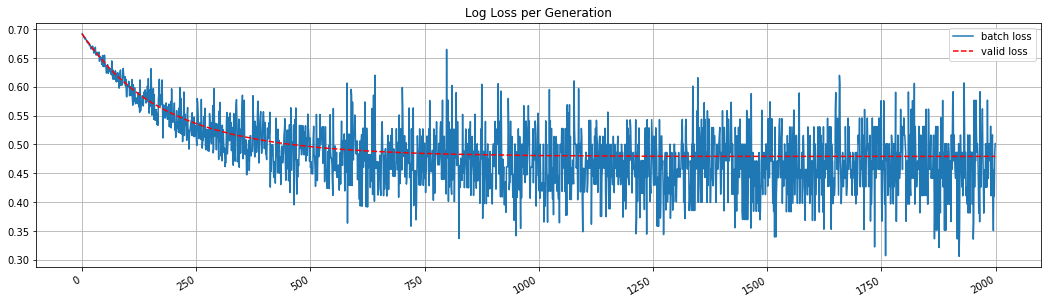

In [43]:
fig = plt.figure(figsize=(18, 5))
ax = plt.subplot()

plt.plot(loss_vec_train,   label='batch loss')
plt.plot(loss_vec_valid,  'r--',  label='valid loss' )
plt.title('Log Loss per Generation')

ax.grid() #グリッド表示
fig.autofmt_xdate() #x軸のオートフォーマット
plt.legend() # 凡例の表示
#plt.savefig('ssss.png')
plt.show()

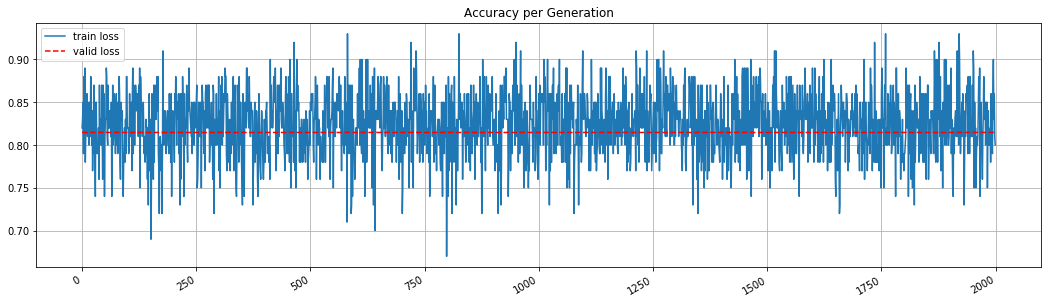

In [45]:
fig = plt.figure(figsize=(18, 5))
ax = plt.subplot()

plt.plot(acc_vec_train,   label='train loss')
plt.plot(acc_vec_valid,  'r--',  label='valid loss' )
plt.title('Accuracy per Generation')

ax.grid() #グリッド表示
fig.autofmt_xdate() #x軸のオートフォーマット
plt.legend() # 凡例の表示
#plt.savefig('ssss.png')
plt.show()

In [47]:
sess.run( p, feed_dict={x: X_valid, y: y_valid})

array([[ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0.18096247],
       [ 0